### iTerms: Deconstructing ToS with LLMs
Defining legal requirements as code enables users to automatically and more efficiently assess compliance with service restrictions. However, non-technical users face significant challenges when translating and understanding these clauses in existing formal languages. With iTerms, we propose a first approach that leverages LLMs as a bridge to translate Terms of Service clauses into the Terms of Service Language (TOSL).

In [ ]:
! pip install langchain
! pip install langchain-openai
! pip install langchain-community
! pip install langchain-core
! pip install pdfplumber
! pip install rdflib requests
! pip install -U "openai>=1.46.0" "langchain>=0.2.12" "langchain-core>=0.2.34" "langchain-openai>=0.1.20"

In [ ]:
import os
import json
from langchain_openai import ChatOpenAI

os.environ["OPENAI_API_KEY"] = ""
model = ChatOpenAI(model="gpt-5", temperature=0)

# Knowledge Graph Construction
## Phase 1: Classification and Metadata Extraction

In the first phase, each clause is analysed to identify its nature and key semantic components.  

- **Input:** use case to be analysed and the clause in natural language  
- **Processing:** classification of the clause and extraction of relevant metadata: `type`, `party`, `action`, and `asset`. These elements are aligned with the TOSL/ODRL vocabulary.  
- **Output:** use case enriched with structured metadata

In [90]:
DEFAULT_ACTIONS = [
    'tosl:allowDownload','tosl:appeal','tosl:assign','tosl:claim','tosl:consent','tosl:develop','tosl:evaluate','tosl:integrate','tosl:procedure','tosl:publish','tosl:remove','tosl:terminate','tosl:test',
    'odrl:acceptTracking','odrl:aggregate','odrl:anonymize','odrl:annotate','odrl:archive','odrl:attribute','odrl:compensate','odrl:concurrentUse','odrl:delete','odrl:derive','odrl:digitize','odrl:display','odrl:distribute','odrl:ensureExclusivity','odrl:execute','odrl:extract','odrl:give','odrl:grantUse','odrl:include','odrl:index','odrl:inform','odrl:install','odrl:modify','odrl:move','odrl:nextPolicy','odrl:obtainConsent','odrl:play','odrl:present','odrl:print','odrl:read','odrl:reproduce','odrl:reviewPolicy','odrl:sell','odrl:stream','odrl:synchronize','odrl:textToSpeech','odrl:transfer','odrl:transform','odrl:translate','odrl:uninstall','odrl:use','odrl:watermark',
    'unspecified'
]

In [91]:
from langchain_openai import ChatOpenAI
from langchain.prompts import ChatPromptTemplate

prompt_template = ChatPromptTemplate.from_template("""
You are a legal analyst specializing in SAAS Terms of Service.

For the following text, perform these steps:

1. Classify it EXCLUSIVELY as one of these 6 labels, in lowercase:
    1. **permission**: When granting a right/authorization (e.g., "may use", "right to access", "is permitted").
    2. **prohibition**: When restricting/forbidding actions (e.g., "may not", "prohibited", "not allowed").
    3. **obligation**: When the party owes or is obliged to do something (e.g., "must pay", "responsible for", "required to maintain", "will").
    4. **dispute resolution**: When establishing legal conflict mechanisms (e.g., "arbitration", "jurisdiction", "governing law").
    5. **liability**: Responsibilities or limitations of liability for damages/warranties/indemnities (e.g., "limitation of liability", "indirect damages", "warranty disclaimer").
    6. **other**: ONLY for:
      - Pure titles/section headers (e.g., "APPENDIX A: DEFINITIONS")
      - Non-substantive text (e.g., "Effective Date: 2025-01-01")
      - Definition lists without operational context

2. Identify the party to whom the clause applies, or the person responsible for performing the action. This should be "Customer", "Provider", or "Both".
Important: 
- If the clause refers to “the parties”, “both parties”, “each party”, you must set party to "Both". 
- Do not use "unspecified" if the party is clearly implied in the text, even if the clause type is "dispute resolution" or "liability".

3. From the list below, identify the Action that is most accurately permitted, obligatory, or prohibited within the clause. Dispute resolution and liability don't have action, it is "unspecified". ONLY SELECT from the predefined list. Not create, modify, or assume new action names.
    {actions_list}

4. Identify the Object of the clause (e.g.,“agreement”, “api service”, “service”, “dataset”, “user content”, “other”). If no asset is clearly specified, write "unspecified".

**Critical Instructions:**
- Understand the context of the clause fully before classifying.
- Special rule: For "dispute resolution" and "liability", action will always be "unspecified". However, party and asset must still be filled if they can be inferred from the text.
- Reason your answer step-by-step, but ONLY provide the final JSON output.

**Response Format:**
Return a JSON object with exactly these fields:

{{
  "type": "<one of the 6 labels>",
  "party": "<the party responsible>",
  "action": "<the action permitted, obligatory or prohibited>",
  "asset": "<the asset>"
}}

Text to analyze:
{clause}
""")

chat_model = ChatOpenAI(
    model="gpt-5",
    temperature=0
)


#### Structured output with function calling

In [92]:
from typing import Literal
from pydantic import BaseModel,Field

AllowedAction = Literal[
    "tosl:allowDownload", "tosl:appeal", "tosl:assign", "tosl:claim", "tosl:consent",
    "tosl:develop", "tosl:evaluate", "tosl:integrate", "tosl:procedure", "tosl:publish",
    "tosl:remove", "tosl:terminate", "tosl:test",
    "odrl:acceptTracking", "odrl:aggregate", "odrl:anonymize", "odrl:annotate", "odrl:archive",
    "odrl:attribute", "odrl:compensate", "odrl:concurrentUse", "odrl:delete", "odrl:derive",
    "odrl:digitize", "odrl:display", "odrl:distribute", "odrl:ensureExclusivity", "odrl:execute",
    "odrl:extract", "odrl:give", "odrl:grantUse", "odrl:include", "odrl:index",
    "odrl:inform", "odrl:install", "odrl:modify", "odrl:move", "odrl:nextPolicy",
    "odrl:obtainConsent", "odrl:play", "odrl:present", "odrl:print", "odrl:read",
    "odrl:reproduce", "odrl:reviewPolicy", "odrl:sell", "odrl:stream", "odrl:synchronize",
    "odrl:textToSpeech", "odrl:transfer", "odrl:transform", "odrl:translate", "odrl:uninstall",
    "odrl:use", "odrl:watermark",
    "unspecified"
]

class ClauseResult(BaseModel):
    type: Literal["permission", "prohibition", "obligation", "dispute resolution", "liability", "other"] = Field(...)
    party: Literal["customer", "provider", "both", "unspecified"] = Field(...)
    action: AllowedAction = Field(...)
    asset: str = Field(..., description="Short noun phrase (<= 3 words)")


In [93]:
structured_llm = chat_model.with_structured_output(ClauseResult)
actions_text = ", ".join(f"`{a}`" for a in DEFAULT_ACTIONS) 
chain = prompt_template.partial(actions_list=actions_text) | structured_llm

def classify_and_extract(clause: str):
    result: ClauseResult = chain.invoke({"clause": clause})
    return result.model_dump()

def process_use_cases(use_cases: dict):
    """
    Itera sobre los use cases y añade los campos.
    """
    for key, value in use_cases.items():
        description = value.get("description", "").strip()
        if not description:
            value["type"] = "other"
            value["party"] = "unspecified"
            value["action"] = "unspecified"
            value["asset"] = "unspecified"
            continue

        result = classify_and_extract(description)
        value["type"] = (result.get("type") or "other").strip().lower()
        value["party"] = (result.get("party") or "unspecified").strip().lower()
        value["action"] = (result.get("action") or "unspecified").strip().lower()
        value["asset"] = (result.get("asset") or "unspecified").strip().lower()

    return use_cases

def main(input_file: str, output_file: str):
    from pathlib import Path
    Path(output_file).parent.mkdir(parents=True, exist_ok=True)
    with open(input_file, "r", encoding="utf-8") as f:
        data = json.load(f)

    use_cases = data.get("USE_CASE_DESCRIPTIONS", {})
    updated = process_use_cases(use_cases)
    data["USE_CASE_DESCRIPTIONS"] = updated

    with open(output_file, "w", encoding="utf-8") as f:
        json.dump(data, f, indent=2, ensure_ascii=False)


In [94]:
if __name__ == "__main__":
    INPUT_JSON = "../data/use_cases_elsevier.json"
    OUTPUT_JSON = "phase1/results/use_cases_elsevier_classifieds.json"

    main(INPUT_JSON, OUTPUT_JSON)


#### Evaluation Phase I

In this phase of the pipeline, we focus on evaluating how well the LLM extracts the key metadata from each clause. Specifically, we compare the fields `type`, `party`, `action`, and `asset` produced by the model with the expected values that were manually annotated in the `data/use_cases_elsevier_classifieds_expected.json` file. This helps us check how accurately the model captures the semantic information necessary to represent the ODRL+TOSL TTL.

In [95]:
import json
import pathlib
import time
import re
from typing import Any, Dict, List, Tuple

ASSET_ALIASES = {
    "api service's web site": "api service",
    "api service’s web site": "api service",
    "api services": "api service",
    "api service access": "api service",
    "api access": "api service",
    "api keys": "api service",
    "api key": "api service",
    "elsevier content": "api service",
    "apis": "api service",
    "apis and services": "api service",
}

FIELDS_EVAL = ["type", "party", "action", "asset"]


# -----------------------------
# Utils
# -----------------------------
def _safe_div(num: float, den: float):
    return num / den if den else 0.0


def _f1_from_pr(p: float, r: float):
    return _safe_div(2 * p * r, (p + r))


def _key_sorter(k: Any):
    """
    Ordena claves con prioridad por sufijo numérico (si existe) y, como desempate,
    por la propia clave como string, garantizando orden estable.
    """
    m = re.search(r"(\d+)$", str(k))
    return (int(m.group(1)) if m else float("inf"), str(k))


# -----------------------------
# Carga de datos
# -----------------------------
def _load_uc(path: str):
    p = pathlib.Path(path)
    try:
        d = json.loads(p.read_text(encoding="utf-8"))
    except FileNotFoundError:
        raise FileNotFoundError(f"No se encuentra el archivo: {p}")
    except json.JSONDecodeError as e:
        raise ValueError(f"JSON inválido en {p}: {e}") from e
    return d.get("USE_CASE_DESCRIPTIONS") or d.get("use_cases") or {}


# -----------------------------
# Normalización de campos
# -----------------------------
def _norm_type(x: Any):
    return "" if x is None else str(x).strip().casefold()


def _norm_party(x: Any, normalize_roles: bool):
    if x is None:
        return ""
    s = str(x).strip()
    return s.casefold() if normalize_roles else s


def _norm_action(x: Any, normalize_actions: bool):
    if x is None:
        return ""
    s = str(x).strip()
    return s.casefold() if normalize_actions else s


def _norm_asset(x: Any, normalize_assets: bool):
    if x is None:
        return ""
    s = str(x).strip()
    if normalize_assets:
        s_low = s.casefold()
        return ASSET_ALIASES.get(s_low, s_low)
    return s


def _normalize_row(row: Dict[str, Any], normalize_actions: bool = False, normalize_roles: bool = False, normalize_assets: bool = True):
    return {
        "type": _norm_type(row.get("type")),
        "party": _norm_party(row.get("party"), normalize_roles),
        "action": _norm_action(row.get("action"), normalize_actions),
        "asset": _norm_asset(row.get("asset"), normalize_assets),
    }


# -----------------------------
# Métricas + matriz de confusión
# -----------------------------
def _confusion_and_metrics(y_true: List[str], y_pred: List[str]):
    labels: List[str] = sorted(set(y_true) | set(y_pred))
    idx = {lab: i for i, lab in enumerate(labels)}
    n = len(labels)

    # Matriz de confusión
    cm: List[List[int]] = [[0] * n for _ in range(n)]
    for t, p in zip(y_true, y_pred):
        cm[idx[t]][idx[p]] += 1

    precision: Dict[str, float] = {}
    recall: Dict[str, float] = {}
    f1: Dict[str, float] = {}
    support: Dict[str, int] = {}

    tp_sum = fp_sum = fn_sum = 0
    for i, lab in enumerate(labels):
        tp = cm[i][i]
        fp = sum(cm[r][i] for r in range(n) if r != i)
        fn = sum(cm[i][c] for c in range(n) if c != i)
        sup = sum(cm[i])

        p = _safe_div(tp, tp + fp)
        r = _safe_div(tp, tp + fn)
        f = _f1_from_pr(p, r)

        precision[lab] = p
        recall[lab] = r
        f1[lab] = f
        support[lab] = sup

        tp_sum += tp
        fp_sum += fp
        fn_sum += fn

    micro_p = _safe_div(tp_sum, tp_sum + fp_sum)
    micro_r = _safe_div(tp_sum, tp_sum + fn_sum)
    micro_f = _f1_from_pr(micro_p, micro_r)

    L = max(len(labels), 1)
    macro_p = sum(precision.values()) / L
    macro_r = sum(recall.values()) / L
    macro_f = sum(f1.values()) / L

    total_support = sum(support.values()) or 1
    weighted_p = sum(precision[l] * support[l] for l in labels) / total_support
    weighted_r = sum(recall[l] * support[l] for l in labels) / total_support
    weighted_f = sum(f1[l] * support[l] for l in labels) / total_support

    total = sum(sum(row) for row in cm)
    correct = sum(cm[i][i] for i in range(n))
    accuracy = _safe_div(correct, total)

    return {
        "labels": labels,
        "confusion": cm,
        "per_label": {
            "precision": precision,
            "recall": recall,
            "f1": f,
            "support": support,
        },
        "micro": {"precision": micro_p, "recall": micro_r, "f1": micro_f},
        "macro": {"precision": macro_p, "recall": macro_r, "f1": macro_f},
        "weighted": {
            "precision": weighted_p,
            "recall": weighted_r,
            "f1": weighted_f,
        },
        "accuracy": accuracy,
        "total": total,
    }


# -----------------------------
# Comparación principal
# -----------------------------
def compare_phase1(pred_path: str, exp_path: str, out_json_path: str, normalize_actions: bool = False, normalize_roles: bool = False, normalize_assets: bool = True,):
    raw_pred = _load_uc(pred_path)
    raw_exp = _load_uc(exp_path)

    keys_all = sorted(set(raw_pred.keys()) | set(raw_exp.keys()), key=_key_sorter)
    keys_eval = sorted(set(raw_pred.keys()) & set(raw_exp.keys()), key=_key_sorter)

    pred_uc: Dict[str, Dict[str, str]] = {
        k: _normalize_row(raw_pred.get(k, {}), normalize_actions, normalize_roles, normalize_assets)
        for k in keys_all
    }
    exp_uc: Dict[str, Dict[str, str]] = {
        k: _normalize_row(raw_exp.get(k, {}), normalize_actions, normalize_roles, normalize_assets)
        for k in keys_all
    }

    per_case = []
    for k in keys_all:
        p = pred_uc[k]
        e = exp_uc[k]
        matches = {f: int(p.get(f) == e.get(f)) for f in FIELDS_EVAL}
        per_case.append({"id": k, "pred": p, "exp": e, "match": matches})

    per_field: Dict[str, Any] = {}
    for f in FIELDS_EVAL:
        y_true = [exp_uc[k].get(f, "") for k in keys_eval]
        y_pred = [pred_uc[k].get(f, "") for k in keys_eval]
        per_field[f] = _confusion_and_metrics(y_true, y_pred)

    result = {
        "meta": {
            "pred_path": pred_path,
            "exp_path": exp_path,
            "n_cases_all": len(keys_all),
            "n_cases_eval": len(keys_eval),
            "normalize_actions": normalize_actions,
            "normalize_roles": normalize_roles,
            "normalize_assets": normalize_assets,
            "ignored": ["description"],
            "timestamp": int(time.time()),
        },
        "per_case": per_case,
        "per_field": per_field,
    }

    out_p = pathlib.Path(out_json_path)
    out_p.parent.mkdir(parents=True, exist_ok=True)
    out_p.write_text(json.dumps(result, ensure_ascii=False, indent=2), encoding="utf-8")
    print(f"✓ Guardado JSON de métricas en {out_p}")
    return result


In [96]:
import json, pathlib
import matplotlib.pyplot as plt
from typing import Sequence, Optional, Mapping, Any

def _load_results(result_or_path):
    return json.loads(pathlib.Path(result_or_path).read_text(encoding="utf-8")) \
           if isinstance(result_or_path, (str, pathlib.Path)) else result_or_path

def _weighted_f1_for_field(res: Mapping[str, Any], field: str) -> float:
    m = res["per_field"][field]
    if "weighted" in m and "f1" in m["weighted"]:
        return float(m["weighted"]["f1"])
    labels = m.get("labels", [])
    per_label = m.get("per_label", {})
    sup = (per_label.get("support") or {})
    f1s = (per_label.get("f1") or {})
    total = sum(sup.values()) or 1
    return sum((float(f1s.get(l, 0.0)) * int(sup.get(l, 0))) for l in labels) / total

def plot_phase1_metrics(result_or_path, save_path: Optional[str] = None, show_weighted: bool = True, fields: Optional[Sequence[str]] = None, title: Optional[str] = None):
    res = _load_results(result_or_path)

    if fields is None:
        try:
            fields = tuple(FIELDS_EVAL)
        except NameError:
            fields = tuple(sorted(res.get("per_field", {}).keys()))
    if not fields:
        raise ValueError("No hay campos para graficar (per_field vacío).")

    accs = []
    f1m  = []
    f1w  = [] if show_weighted else None
    for f in fields:
        m = res.get("per_field", {}).get(f, {})
        accs.append(float(m.get("accuracy", 0.0)))
        f1m.append(float((m.get("macro") or {}).get("f1", 0.0)))
        if show_weighted:
            f1w.append(_weighted_f1_for_field(res, f))  

    plt.figure(figsize=(10, 4.2))
    x = list(range(len(fields)))
    w = 0.28

    def _bar_positions(offset: float):
        return [i + offset for i in x]

    pastel = ['#a1c9f4', '#ffb482', '#8de5a1'] 

    bars1 = plt.bar(_bar_positions(-(w if show_weighted else w/2)), accs, width=w, label="Accuracy", color=pastel[0])
    bars2 = plt.bar(_bar_positions(0 if show_weighted else w/2), f1m, width=w, label="Macro-F1", color=pastel[1])
    if show_weighted:
        bars3 = plt.bar(_bar_positions(w), f1w, width=w, label="Weighted-F1", color=pastel[2])

    plt.xticks(x, [str(f).capitalize() for f in fields])
    ymax = max([*accs, *f1m, *(f1w or [0.0]), 1.0])
    plt.ylim(0, min(1.05, ymax + 0.08))
    plt.grid(axis="y", alpha=0.25)
    plt.title(title or f"Phase 1 — Accuracy vs Macro-F1" + (" (Weighted-F1)" if show_weighted else ""))

    def annotate(bars):
        for b in bars:
            h = b.get_height()
            y = min(h + 0.03, plt.ylim()[1] - 0.01)  
            plt.text(b.get_x() + b.get_width()/2, y, f"{h:.2f}", ha="center", va="bottom", fontsize=9)

    annotate(bars1); annotate(bars2)
    if show_weighted:
        annotate(bars3)

    plt.legend()
    plt.tight_layout()

    if save_path:
        pathlib.Path(save_path).parent.mkdir(parents=True, exist_ok=True)
        plt.savefig(save_path, dpi=160, bbox_inches="tight")
        print(f"Saved chart to {save_path}")
    plt.show()


✓ Guardado JSON de métricas en phase1/eval/elsevier_metadata_results.json
Saved chart to phase1/eval/metrics.png


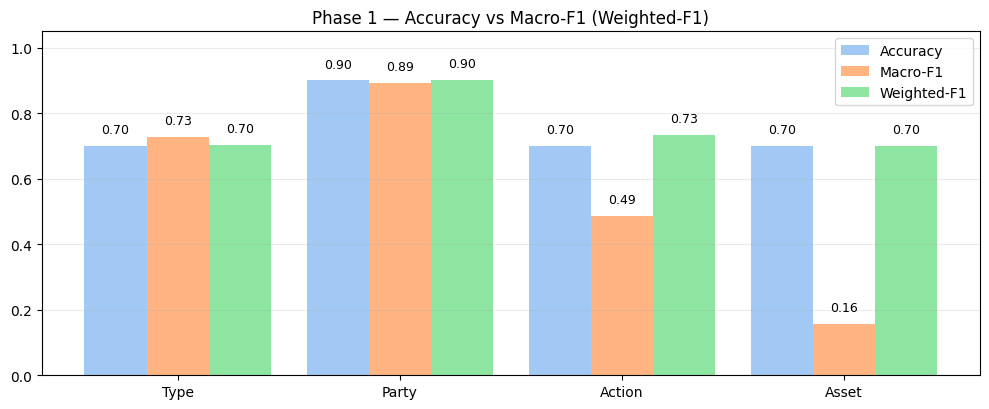

In [97]:
res = compare_phase1(
    pred_path="phase1/results/use_cases_elsevier_classifieds.json",
    exp_path="../data/use_cases_elsevier_classifieds_expected.json",
    out_json_path="phase1/eval/elsevier_metadata_results.json",
    normalize_actions=False, normalize_roles=False, normalize_assets=True)

plot_phase1_metrics(res, save_path="phase1/eval/metrics.png", show_weighted=True)

-------

## Phase 2: Turtle Generation Guided by Template and Ontology

The second phase focuses on transforming the enriched representation into an interoperable semantic format.  

- **Inputs:** enriched use case, a Markdown-based template serving as a construction guide, and the TOSL/ODRL ontology as a semantic reference  
- **Processing:** application of the template and the metamodel to generate RDF statements in Turtle syntax  
- **Output:** Turtle file corresponding to the processed clause  

In [98]:
def load_use_cases(json_path):
    """
    Carga el JSON y devuelve una lista de diccionarios con los campos relevantes.
    """
    with open(json_path, "r", encoding="utf-8") as f:
        data = json.load(f)

    global_metadata = {
        "PROVIDER": data.get("PROVIDER", "Unknown"),
        "SOURCE": data.get("SOURCE", "Unknown"),
        "TITLE": data.get("TITLE", "Unknown"),
        "DATE": data.get("DATE", "Unknown")
    }

    use_cases = []
    for key, item in data.get("USE_CASE_DESCRIPTIONS", {}).items():
        clause = item.get("description", "").strip()
        classification = item.get("type", "").strip().lower()

        # Si Party o Asset no están, usa valores por defecto
        party = item.get("party", "UnknownParty")
        action = item.get("action", "UnknownAction")
        asset = item.get("asset", "UnknownAsset")

        use_cases.append({
            "id": key,
            "clause": clause,
            "type": classification,
            "party": party,
            "action": action,
            "asset": asset
        })

    return use_cases, global_metadata

In [99]:
def extract_text_from_md(md_path):
  with open(md_path, "r", encoding="utf-8") as f:
      content = f.read()
  return content

In [100]:
def extract_ttl(content):
    start_tag = "```ttl"
    end_tag = "```"
    start_idx = content.find(start_tag)
    end_idx = content.rfind(end_tag)

    if start_idx == -1 or end_idx == -1:
        raise ValueError("No se encontraron los delimitadores ```ttl")

    # Extraer solo la parte del TTL
    ttl = content[start_idx + len(start_tag):end_idx].strip()
    return ttl

In [101]:
def save_prompt(prompt_text, uc_id):
    path = f"phase2/results/prompt-{uc_id}.txt"
    with open(path, "w") as f:
        f.write(prompt_text)

def save_ttl(ttl_text, uc_id):
    path = f"phase2/results/{uc_id}.ttl"
    with open(path, "w", encoding="utf-8") as f:
        f.write(ttl_text)

In [102]:
def build_prompt(template_text, clause_info, global_metadata):
    """
    Construye un prompt de modelado RDF en Turtle.
    """
    prompt = f"""
        You are a legal knowledge extractor specialized in TOSL and ODRL policy modeling.

        TASKS:
        - Read the clause.
        - Produce a SINGLE minimal ODRL/TOSL policy in Turtle.

        Guidelines:
        - Output MUST be valid Turtle inside a single fenced code block: ```ttl … ```
        - Use only the vocabulary and structure provided in the reference template in markdown.
        - Use ONLY the classes, properties, prefixes, and shapes that appear in the reference template below.
        - All URIs and prefixes must be exactly as shown.
        - Do not add explanations, headers, or any commentary.

        Reference template: 
        {template_text}

        Metadata:
          - Provider: {global_metadata.get("PROVIDER", "Unknown")}
          - Source: {global_metadata.get("SOURCE", "Unknown")}
          - Title: {global_metadata.get("TITLE", "Unknown")}
          - Date: {global_metadata.get("DATE", "Unknown")}

        Clause to model: {clause_info['clause']}

        Classification type: {clause_info['type']}

        Party: {clause_info['party']}

        Suggested Action: {clause_info['action']}

        Target asset: {clause_info['asset']}
        """
    return prompt.strip()


def main(json_path, md_path):
    """
    Orquesta el flujo:
    1. Lee JSON.
    2. Lee template markdown.
    3. Construye prompts para cada cláusula.
    """
    use_cases, global_metadata = load_use_cases(json_path)
    tosl_guidelines_text = extract_text_from_md(md_path)
    os.makedirs("phase2/results", exist_ok=True)

    for uc in use_cases:
      prompt_text = build_prompt(tosl_guidelines_text, uc, global_metadata)
      save_prompt(prompt_text, uc['id'])
      messages = [
          {"role": "system", "content": "You are a legal knowledge extractor specialized in TOSL and ODRL policy modeling."},
          {"role": "user", "content": prompt_text}
      ]
      response = model.invoke(messages)

      print("======================================")
      print(f"{uc['id']}")
      print("======================================")
      print(response.content)
      ttl_text = extract_ttl(response.content)
      save_ttl(ttl_text, uc['id'])
      print(f"✅ Archivo guardado")
      print("\n\n")


In [104]:
if __name__ == "__main__":
    json_path = "phase1/results/use_cases_elsevier_classifieds.json"
    md_path = "../metamodel/tosl_guidelines.md"

    main(json_path, md_path)

use_case_16
```ttl
@prefix : <http://example.com/> .
@prefix owl: <http://www.w3.org/2002/07/owl#> .
@prefix rdf: <http://www.w3.org/1999/02/22-rdf-syntax-ns#> .
@prefix xml: <http://www.w3.org/XML/1998/namespace> .
@prefix xsd: <http://www.w3.org/2001/XMLSchema#> .
@prefix rdfs: <http://www.w3.org/2000/01/rdf-schema#> .
@prefix skos: <http://www.w3.org/2004/02/skos/core#> .
@prefix dcterms: <http://purl.org/dc/terms/> .
@prefix foaf: <http://xmlns.com/foaf/0.1/> .
@prefix odrl: <http://www.w3.org/ns/odrl/2/> .
@prefix tosl: <https://w3id.org/tosl/> .
@base <http://example.com> .

:Elsevier a tosl:Provider ;
    dcterms:description "Elsevier B.V., provider of the API."^^xsd:string ;
    foaf:name "ELSEVIER" ;
    foaf:homepage <https://dev.elsevier.com/> .

:customer a tosl:Customer ;
    dcterms:description "Developer using the Elsevier API under this agreement."^^xsd:string .

:apiContent a odrl:Asset ;
    dcterms:description "Content obtained via the Elsevier API."^^xsd:string .

:

#### Evaluation Phase II

In Phase II of the pipeline, we work with the first version of the clause representation in TTL. Our validation focuses on checking whether the generated TTL contains any syntax or semantic errors according to the TOSL language, using the validator available at [https://tosl.onrender.com/docs](https://tosl.onrender.com/docs). This process provides a detailed list of typing issues and missing mandatory attributes in the representation. Based on this, we calculate the percentage of use cases that successfully pass the validation and analyse the range of errors found in those that do not have a correct construction.

In [105]:
import requests

PREFIXES = {
    "http://www.w3.org/ns/shacl#": "sh:",
    "http://www.w3.org/ns/odrl/2/": "odrl:",
    "https://w3id.org/tosl/": "tosl:",
    "http://example.com/": ":",
    "http://www.w3.org/2001/XMLSchema#": "xsd:",
}
def short(u: str) -> str:
    if not u:
        return ""
    for base, pfx in PREFIXES.items():
        if u.startswith(base):
            return pfx + u[len(base):]
    return u

def tosl_checker(url, file_path):
    with open(file_path, "rb") as f:
        r = requests.post(url, files={"file": ("use_case.ttl", f, "text/turtle")})

    print("Código de estado:", r.status_code)
    try:
        data = r.json()
    except Exception:
        print("Respuesta no-JSON:\n", r.text)
        return None

    ok = bool(data.get("conforms") or data.get("valid"))
    print("✅ Conforms" if ok else "❌ Violations")

    if ok:
        return data

    for i, v in enumerate(data.get("violations", []), 1):
        focus = short(v.get("focusNode", ""))
        path  = short(v.get("resultPath", ""))
        value = short(v.get("valueNode", ""))
        msg   = v.get("message", "")
        head = f"{focus} --{path}--> {value}" if path else focus or value or "(sin nodo)"
        print(f"  {i}. {head}")
        if msg:
            print(f"      {msg}")

    return data


[i] phase2/results/use_case_1.ttl
Código de estado: 200
✅ Conforms

[i] phase2/results/use_case_10.ttl
Código de estado: 200
✅ Conforms

[i] phase2/results/use_case_11.ttl
Código de estado: 200
✅ Conforms

[i] phase2/results/use_case_12.ttl
Código de estado: 200
✅ Conforms

[i] phase2/results/use_case_13.ttl
Código de estado: 200
✅ Conforms

[i] phase2/results/use_case_14.ttl
Código de estado: 200
✅ Conforms

[i] phase2/results/use_case_15.ttl
Código de estado: 200
✅ Conforms

[i] phase2/results/use_case_16.ttl
Código de estado: 200
✅ Conforms

[i] phase2/results/use_case_17.ttl
Código de estado: 200
✅ Conforms

[i] phase2/results/use_case_18.ttl
Código de estado: 200
✅ Conforms

[i] phase2/results/use_case_19.ttl
Código de estado: 200
❌ Violations
  1. :agreement01 --odrl:permission--> :permission01
      If present, permission must conform to PermissionShape.
  2. :permission01 --odrl:assignee--> 
      The assignee must be a tosl:Provider, tosl:Customer, or tosl:BusinessCustomer.



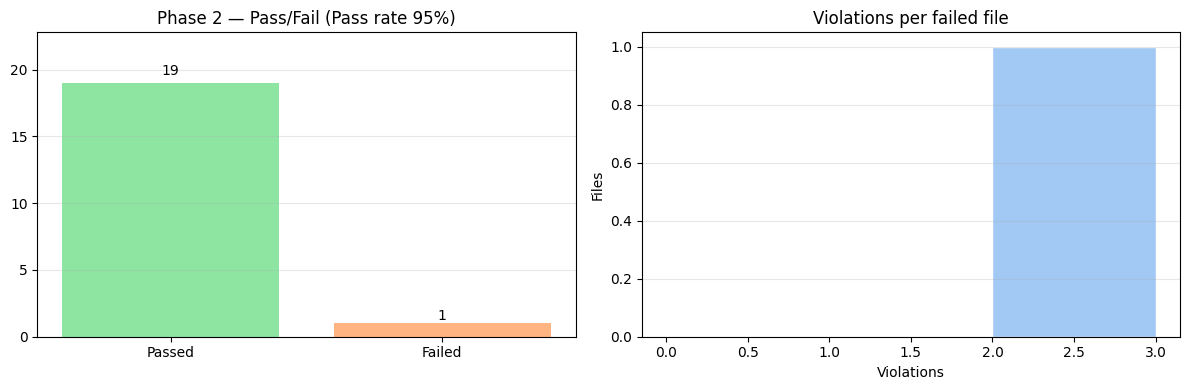

In [106]:
import json, pathlib
import matplotlib.pyplot as plt

VALIDATOR_URL = "https://tosl.onrender.com/validator/validate"

def phase2_validate_and_plot( url: str = VALIDATOR_URL, in_globs = ("phase2/results/*.ttl",), out_json: str = "phase2/eval/elsevier_ttls_results.json",
    out_plot: str = "phase2/eval/elsevier_ttls_results_plot.png", show_hist: bool = True):

    paths = []
    for g in in_globs:
        paths.extend(pathlib.Path(".").glob(g))
    paths = sorted(set(paths), key=lambda p: str(p))

    out_path = pathlib.Path(out_json)
    out_path.parent.mkdir(parents=True, exist_ok=True)
    pathlib.Path(out_plot).parent.mkdir(parents=True, exist_ok=True)

    results = {}
    for p in paths:
        print(f"\n[i] {p}")
        report = tosl_checker(url, str(p)) or {}
        passed = bool(report.get("conforms") or report.get("valid"))
        errors = len(report.get("violations", [])) if isinstance(report, dict) else None
        results[str(p)] = {"passed": passed, "errors": errors}

    out_path.write_text(json.dumps(results, ensure_ascii=False, indent=2), encoding="utf-8")
    print(f"\nSaved JSON: {out_path} ({len(results)} items)")

    if isinstance(results, dict):
        vals = list(results.values())
    elif isinstance(results, list):
        vals = results
    else:
        raise TypeError(f"Unsupported results type: {type(results).__name__}")
    passed_n = sum(1 for v in vals if v.get("passed"))
    failed_n = len(vals) - passed_n
    pass_rate = (passed_n / (passed_n + failed_n) * 100) if (passed_n + failed_n) else 0.0

    c_pass, c_fail, c_hist = "#8de5a1", "#ffb482", "#a1c9f4"

    if show_hist:
        fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(12, 4))
    else:
        fig, ax0 = plt.subplots(1, 1, figsize=(7, 4))

    ax0.bar(["Passed", "Failed"], [passed_n, failed_n], color=[c_pass, c_fail])
    for i, v in enumerate([passed_n, failed_n]):
        ax0.text(i, v + max(1, v) * 0.02, f"{v}", ha="center", va="bottom", fontsize=10)
    ax0.set_ylim(0, max(1, passed_n, failed_n) * 1.2)
    ax0.set_title(f"Phase 2 — Pass/Fail (Pass rate {pass_rate:.0f}%)")
    ax0.grid(axis="y", alpha=0.3)

    if show_hist:
        errors = [int(v.get("errors") or 0) for v in vals if not v.get("passed")]
        if errors:
            bins = range(0, max(errors) + 2)
            ax1.hist(errors, bins=bins, color=c_hist, edgecolor="white")
            ax1.set_title("Violations per failed file")
            ax1.set_xlabel("Violations")
            ax1.set_ylabel("Files")
            ax1.grid(axis="y", alpha=0.3)
        else:
            ax1.axis("off")
            ax1.text(0.5, 0.5, "No failed files", ha="center", va="center", fontsize=11)

    plt.tight_layout()
    plt.savefig(out_plot, dpi=160)
    print(f"Saved plot: {out_plot}")
    plt.show()

    return results

if __name__ == "__main__":
    phase2_validate_and_plot()


-------

## Phase 3: Validation and Self-repair
This phase ensures the syntactic and semantic correctness of the output.  

- **Input:** Turtle file generated in the previous phase  
- **Processing:**  
  - Syntactic validation using standard Turtle validation tools  
  - Semantic validation using a custom validator based on TOSL/ODRL rules  
  - **AI-assisted self-repair** to automatically correct inconsistencies  
- **Outputs:**  
  1. Error report  
  2. Corrected and validated Turtle file  

In [107]:
def build_prompt_fix_ttl(template_text, instance_ttl, validator_errors_json):
    """
    Builds a prompt to FIX a Turtle file using an ontology and validator feedback.
    Output is requested as a fenced ```ttl code block.
    """
    prompt = f"""
        You are a knowledge engineer specialized in RDF/Turtle and ontology-driven validation.

        Tasks:
        - Read the original Turtle file and the validator violations.
        - Fix ALL violations so that the file conforms to the given TOSL guidelines.
        - Preserve all correct information and the original meaning whenever possible.

        Guidelines:
        - Output MUST be valid Turtle inside a single fenced code block: ```ttl … ```
        - Use only the vocabulary and structure provided in the reference template in markdown.
        - Use ONLY the classes, properties, prefixes, and shapes that appear in the reference template below.
        - All URIs and prefixes must be exactly as shown.
        - Do not add explanations, headers, or any commentary.
        - Be careful and not introduce new errors.

        Reference template: 
        {template_text}

        Validator errors (JSON):
        {validator_errors_json}

        Original file (Turtle):
        {instance_ttl}

        IMPORTANT:
        - Think step by step internally, but return ONLY the corrected Turtle in a ```ttl fenced block.
    """
    return prompt.strip()


In [108]:
import json
from pathlib import Path

URL = "https://tosl.onrender.com/validator/validate"
IN_DIR = Path("phase2/results")
OUT_DIR = Path("phase3/results")
EVAL_JSON = Path("phase3/eval/elsevier_ttls_results.json")
GUIDELINES_PATH = Path("../metamodel/tosl_guidelines.md")

def _violations_count(report):
    if isinstance(report, dict) and isinstance(report.get("violations"), list):
        return len(report["violations"])
    return 0

def _save_results(path: Path, results):
    path.parent.mkdir(parents=True, exist_ok=True)
    path.write_text(json.dumps(results, ensure_ascii=False, indent=2), encoding="utf-8")

def main():
    OUT_DIR.mkdir(parents=True, exist_ok=True)
    EVAL_JSON.parent.mkdir(parents=True, exist_ok=True)

    template_text = extract_text_from_md(str(GUIDELINES_PATH))

    phase3_results = []

    for i in range(1, 21):
        in_file = IN_DIR / f"use_case_{i}.ttl"
        out_file = OUT_DIR / f"use_case_{i}.ttl"

        print(f"[i] use_case_{i}.ttl")

        if not in_file.exists():
            phase3_results.append({
                "file": in_file.name,
                "outfile": str(out_file),
                "passed": False,
                "errors": 1,
                "report": {"error": "Missing input TTL in phase2/results"}
            })
            continue

        report_phase2 = tosl_checker(URL, str(in_file))
        ok_phase2 = bool(report_phase2.get("conforms") or report_phase2.get("valid"))

        if ok_phase2:
            out_file.write_text(in_file.read_text(encoding="utf-8"), encoding="utf-8")
            print(f"    ✅ Conforms (fase 2) | Copiado a fase 3: {out_file.name}")
        else:
            prompt_text = build_prompt_fix_ttl(
                template_text=template_text,
                instance_ttl=in_file.read_text(encoding="utf-8"),
                validator_errors_json=report_phase2.get("violations", []),
            )
            messages = [
                {"role": "system", "content": "You are a strict RDF/Turtle engineer."},
                {"role": "user", "content": prompt_text},
            ]
            response = model.invoke(messages)
            ttl_text = extract_ttl(response.content)
            out_file.write_text(ttl_text, encoding="utf-8")
            print(f"    Generado fix → {out_file.name}")

        report_phase3 = tosl_checker(URL, str(out_file))
        ok_phase3 = bool(report_phase3.get("conforms") or report_phase3.get("valid"))
        errs_phase3 = _violations_count(report_phase3)

        phase3_results.append({
            "file": in_file.name,
            "outfile": str(out_file),
            "passed": ok_phase3,
            "errors": errs_phase3,
            "report": report_phase3,
        })

        print("Resultado fase 3:", "✅ Conforms" if ok_phase3 else f"❌ No conforms ({errs_phase3} violations)")

    _save_results(EVAL_JSON, phase3_results)
    print(f"\n[✓] JSON guardado con SOLO fase 3 (ordenado): {EVAL_JSON}")

if __name__ == "__main__":
    main()


[i] use_case_1.ttl
Código de estado: 200
✅ Conforms
    ✅ Conforms (fase 2) | Copiado a fase 3: use_case_1.ttl
Código de estado: 200
✅ Conforms
Resultado fase 3: ✅ Conforms
[i] use_case_2.ttl
Código de estado: 200
✅ Conforms
    ✅ Conforms (fase 2) | Copiado a fase 3: use_case_2.ttl
Código de estado: 200
✅ Conforms
Resultado fase 3: ✅ Conforms
[i] use_case_3.ttl
Código de estado: 200
✅ Conforms
    ✅ Conforms (fase 2) | Copiado a fase 3: use_case_3.ttl
Código de estado: 200
✅ Conforms
Resultado fase 3: ✅ Conforms
[i] use_case_4.ttl
Código de estado: 200
✅ Conforms
    ✅ Conforms (fase 2) | Copiado a fase 3: use_case_4.ttl
Código de estado: 200
✅ Conforms
Resultado fase 3: ✅ Conforms
[i] use_case_5.ttl
Código de estado: 200
✅ Conforms
    ✅ Conforms (fase 2) | Copiado a fase 3: use_case_5.ttl
Código de estado: 200
✅ Conforms
Resultado fase 3: ✅ Conforms
[i] use_case_6.ttl
Código de estado: 200
✅ Conforms
    ✅ Conforms (fase 2) | Copiado a fase 3: use_case_6.ttl
Código de estado: 200
✅ 

#### Evaluation Phase III

 The evaluation of this phase consists of running the TOSL validator ([https://tosl.onrender.com/docs](https://tosl.onrender.com/docs)) again to verify whether the errors have been successfully corrected.

In [109]:
import json, pathlib
import matplotlib.pyplot as plt

def plot_results(results_path, out_plot=None, show_hist=True, title_prefix="Phase 3"):
    if isinstance(results_path, (str, pathlib.Path)):
        results = json.loads(pathlib.Path(results_path).read_text(encoding="utf-8"))
    else:
        results = results_path

    def _pe(v):
        if "passed" in v:
            return bool(v.get("passed")), int(v.get("errors") or 0)
        if "after_fix" in v:
            return bool(v["after_fix"].get("passed")), int(v["after_fix"].get("errors") or 0)
        if "initial" in v:
            return bool(v["initial"].get("passed")), int(v["initial"].get("errors") or 0)
        return False, 0

    vals = results if isinstance(results, list) else list(results.values())
    flags, errs_failed = [], []
    for v in vals:
        p, e = _pe(v)
        flags.append(p)
        if not p:
            errs_failed.append(e)

    passed_n = sum(1 for p in flags if p)
    failed_n = len(flags) - passed_n
    pass_rate = (passed_n / (passed_n + failed_n) * 100) if (passed_n + failed_n) else 0.0

    # 3) Colores y layout idénticos
    c_pass, c_fail, c_hist = "#8de5a1", "#ffb482", "#a1c9f4"

    if show_hist:
        fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(12, 4))
    else:
        fig, ax0 = plt.subplots(1, 1, figsize=(7, 4))

    # Barras Passed/Failed
    ax0.bar(["Passed", "Failed"], [passed_n, failed_n], color=[c_pass, c_fail])
    for i, v in enumerate([passed_n, failed_n]):
        ax0.text(i, v + max(1, v) * 0.02, f"{v}", ha="center", va="bottom", fontsize=10)
    ax0.set_ylim(0, max(1, passed_n, failed_n) * 1.2)
    ax0.set_title(f"{title_prefix} — Pass/Fail (Pass rate {pass_rate:.0f}%)")
    ax0.grid(axis="y", alpha=0.3)

    # Histograma de violaciones por archivo fallido
    if show_hist:
        if errs_failed:
            bins = range(0, max(errs_failed) + 2)
            ax1.hist(errs_failed, bins=bins, color=c_hist, edgecolor="white")
            ax1.set_title("Violations per failed file")
            ax1.set_xlabel("Violations")
            ax1.set_ylabel("Files")
            ax1.grid(axis="y", alpha=0.3)
        else:
            ax1.axis("off")
            ax1.text(0.5, 0.5, "No failed files", ha="center", va="center", fontsize=11)

    plt.tight_layout()
    if out_plot:
        pathlib.Path(out_plot).parent.mkdir(parents=True, exist_ok=True)
        plt.savefig(out_plot, dpi=160)
        print(f"Saved plot: {out_plot}")
    plt.show()

    return {"passed": passed_n, "failed": failed_n, "total": len(flags), "pass_rate": pass_rate}


Saved plot: phase3/eval/elsevier_refactor_ttls_results_plot.png


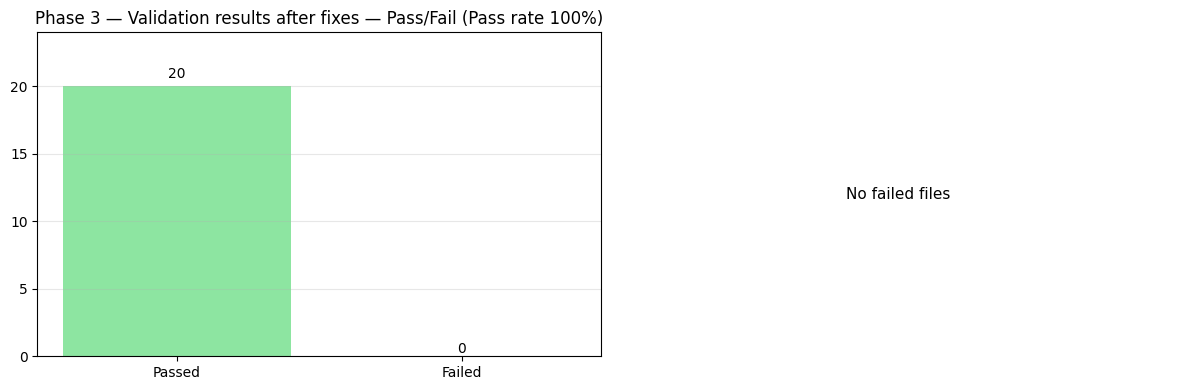

{'passed': 20, 'failed': 0, 'total': 20, 'pass_rate': 100.0}

In [110]:
plot_results("phase3/eval/elsevier_ttls_results.json",
                        out_plot="phase3/eval/elsevier_refactor_ttls_results_plot.png",
                        show_hist=True,
                        title_prefix="Phase 3 — Validation results after fixes")


------

# SPARQL queries

- Deontic modalities 
- Potentially unfair terms


In [111]:
import json, time, pathlib, concurrent.futures as cf
import requests
from requests.adapters import HTTPAdapter
from urllib3.util.retry import Retry

DEONTIC_URL = "https://tosl.onrender.com/sparql/deontic_status"
UNFAIR_URL  = "https://tosl.onrender.com/sparql/unfair_terms"

DEONTIC_KEEP = ["get_duties", "get_permissions", "get_prohibitions", "total_rules"]

TERM_TYPES = [
    "change",
    "termination",
    "contract_by_use",
    "choice_of_law",
    "jurisdiction",
    "arbitration",
    "content_removal",
    "limitation_of_liability",
]

SHORTEN = True
PREFIXES = {
    "http://www.w3.org/ns/odrl/2/": "odrl:",
    "https://w3id.org/tosl/": "tosl:",
    "http://purl.org/dc/terms/": "dcterms:",
    "http://example.com/": ":",
    "http://www.w3.org/2001/XMLSchema#": "xsd:",
}

S = requests.Session()
S.headers.update({"Accept": "application/sparql-results+json", "Accept-Encoding": "gzip, deflate"})
S.mount("https://", HTTPAdapter(max_retries=Retry(
    total=3, backoff_factor=0.6, status_forcelist=[429, 500, 502, 503, 504], allowed_methods=["POST"]
)))
TIMEOUT = 60

def short(u: str):
    if not SHORTEN or not isinstance(u, str):
        return u
    for base, pfx in PREFIXES.items():
        if u.startswith(base):
            return pfx + u[len(base):]
    return u

def to_rows(payload):
    if isinstance(payload, list):
        return payload
    if isinstance(payload, dict) and "results" in payload:
        vars_ = payload.get("head", {}).get("vars", [])
        return [{v: b.get(v, {}).get("value") for v in payload["results"].get("bindings", [])}
                for b in payload["results"].get("bindings", [])]
    return []

def as_list(x):
    if x is None or x == "":
        return []
    if isinstance(x, list):
        return [short(v) for v in x]
    return [short(v.strip()) for v in str(x).split(",") if v.strip()]

def norm_deontic_row(row):
    rid = row.get("duty") or row.get("permission") or row.get("prohibition") or row.get("rule") or row.get("element")
    return {
        "id": short(rid),
        "actions": as_list(row.get("actions") or row.get("action")),
        "targets": as_list(row.get("targets") or row.get("target")),
        "assignee": short(row.get("assignee")),
        "assigner": short(row.get("assigner")),
        "description": row.get("description"),
    }

def post_file(url, ttl_path, params=None):
    t0 = time.time()
    ttl_path = pathlib.Path(ttl_path)
    with open(ttl_path, "rb") as f:
        r = S.post(url, params=params or {}, files={"file": (ttl_path.name, f, "text/turtle")}, timeout=TIMEOUT)
    ms = int((time.time() - t0) * 1000)
    try:
        data, ok_json = r.json(), True
    except Exception:
        data, ok_json = {"non_json": r.text[:4000]}, False
    return {"status": r.status_code, "ms": ms, "ok": r.ok and ok_json, "data": data}

def run_all_for_file(ttl_path: str):
    ttl_path = str(ttl_path)
    out = {
        "file": ttl_path,
        "deontic": {
            "total_rules": 0,
            "duties": [],
            "permissions": [],
            "prohibitions": [],
        },
        "unfair_terms": {},
        "_meta": {"calls": 0, "ok": 0, "ms_total": 0}, 
    }

    for q in DEONTIC_KEEP:
        res = post_file(DEONTIC_URL, ttl_path, params={"deontic_status": q})
        out["_meta"]["calls"] += 1
        out["_meta"]["ok"] += int(bool(res["ok"]))
        out["_meta"]["ms_total"] += res["ms"]
        rows = to_rows(res["data"]) if res["ok"] else []
        if q == "total_rules":
            val = 0
            if rows:
                raw = rows[0].get("totalElements")
                try: val = int(raw or 0)
                except Exception: val = 0
            out["deontic"]["total_rules"] = val
        elif q == "get_duties":
            out["deontic"]["duties"] = [norm_deontic_row(r) for r in rows]
        elif q == "get_permissions":
            out["deontic"]["permissions"] = [norm_deontic_row(r) for r in rows]
        elif q == "get_prohibitions":
            out["deontic"]["prohibitions"] = [norm_deontic_row(r) for r in rows]

    for tt in TERM_TYPES:
        res = post_file(UNFAIR_URL, ttl_path, params={"term_type": tt})
        out["_meta"]["calls"] += 1
        out["_meta"]["ok"] += int(bool(res["ok"]))
        out["_meta"]["ms_total"] += res["ms"]
        rows = to_rows(res["data"]) if res["ok"] else []
        clean = []
        for r in rows:
            clean.append({k: (as_list(v) if k in ("actions", "targets") else short(v)) for k, v in r.items()})
        out["unfair_terms"][tt] = clean

    return out

def run_batch(in_glob="phase3/results/*.ttl", out_dir="evaluation", max_workers=6):
    in_paths = sorted(pathlib.Path(".").glob(in_glob))
    out_dir = pathlib.Path(out_dir); out_dir.mkdir(parents=True, exist_ok=True)

    def _save(res: dict):
        p = pathlib.Path(res["file"])
        out_path = out_dir / f"{p.stem}_results.json"
        out_path.write_text(json.dumps(res, ensure_ascii=False, indent=2))
        return out_path

    index = []
    with cf.ThreadPoolExecutor(max_workers=max_workers) as ex:
        futs = {ex.submit(run_all_for_file, str(p)): str(p) for p in in_paths}
        for fut in cf.as_completed(futs):
            res = fut.result()
            saved = _save(res)
            index.append({"file": res["file"], "out": str(saved), "calls": res["_meta"]["calls"], "ok": res["_meta"]["ok"]})
            print(f"✓ {res['file']} -> {saved.name} | {res['_meta']['ok']}/{res['_meta']['calls']} OK")

    (out_dir / "_index.json").write_text(json.dumps(index, ensure_ascii=False, indent=2))
    return index

run_batch(in_glob="phase3/results/*.ttl", out_dir="evaluation", max_workers=6)


✓ phase3/results/use_case_1.ttl -> use_case_1_results.json | 12/12 OK
✓ phase3/results/use_case_13.ttl -> use_case_13_results.json | 12/12 OK
✓ phase3/results/use_case_12.ttl -> use_case_12_results.json | 12/12 OK
✓ phase3/results/use_case_11.ttl -> use_case_11_results.json | 12/12 OK
✓ phase3/results/use_case_10.ttl -> use_case_10_results.json | 12/12 OK
✓ phase3/results/use_case_14.ttl -> use_case_14_results.json | 12/12 OK
✓ phase3/results/use_case_15.ttl -> use_case_15_results.json | 12/12 OK
✓ phase3/results/use_case_17.ttl -> use_case_17_results.json | 12/12 OK
✓ phase3/results/use_case_16.ttl -> use_case_16_results.json | 12/12 OK
✓ phase3/results/use_case_19.ttl -> use_case_19_results.json | 12/12 OK
✓ phase3/results/use_case_18.ttl -> use_case_18_results.json | 12/12 OK
✓ phase3/results/use_case_2.ttl -> use_case_2_results.json | 12/12 OK
✓ phase3/results/use_case_20.ttl -> use_case_20_results.json | 12/12 OK
✓ phase3/results/use_case_3.ttl -> use_case_3_results.json | 12/12 O

[{'file': 'phase3/results/use_case_1.ttl',
  'out': 'evaluation/use_case_1_results.json',
  'calls': 12,
  'ok': 12},
 {'file': 'phase3/results/use_case_13.ttl',
  'out': 'evaluation/use_case_13_results.json',
  'calls': 12,
  'ok': 12},
 {'file': 'phase3/results/use_case_12.ttl',
  'out': 'evaluation/use_case_12_results.json',
  'calls': 12,
  'ok': 12},
 {'file': 'phase3/results/use_case_11.ttl',
  'out': 'evaluation/use_case_11_results.json',
  'calls': 12,
  'ok': 12},
 {'file': 'phase3/results/use_case_10.ttl',
  'out': 'evaluation/use_case_10_results.json',
  'calls': 12,
  'ok': 12},
 {'file': 'phase3/results/use_case_14.ttl',
  'out': 'evaluation/use_case_14_results.json',
  'calls': 12,
  'ok': 12},
 {'file': 'phase3/results/use_case_15.ttl',
  'out': 'evaluation/use_case_15_results.json',
  'calls': 12,
  'ok': 12},
 {'file': 'phase3/results/use_case_17.ttl',
  'out': 'evaluation/use_case_17_results.json',
  'calls': 12,
  'ok': 12},
 {'file': 'phase3/results/use_case_16.ttl'

In [114]:
import json
import re
from pathlib import Path
from typing import Iterable, List, Dict, Any, Union, Tuple

import matplotlib.pyplot as plt


def _natural_case_id(s: str) -> int:
    """Extract the numeric use-case ID from a path or name.

    Prioritize patterns like 'use_case_<N>'. If not found, take the last
    number in the string. Avoid picking the '3' from 'phase3/'.
    """
    s = str(s)
    m = re.search(r"use_case_(\d+)", s)
    if m:
        return int(m.group(1))
    nums = re.findall(r"(\d+)", s)
    return int(nums[-1]) if nums else 10**9


def _humanize(key: str) -> str:
    mapping = {
        "contract_by_use": "contract by use",
        "choice_of_law": "choice of law",
        "limitation_of_liability": "limitation of liability",
        "content_removal": "content removal",
    }
    return mapping.get(key, key.replace("_", " "))


def load_eval_results(src: Union[str, Path, Iterable[Union[str, Path]]]) -> List[Dict[str, Any]]:
    """Load evaluation results.

    - If `src` is a directory: loads all *_results.json files within.
    - If `src` is a file: loads JSON (list or single dict).
    - If `src` is an iterable of files: loads each.
    """
    if isinstance(src, (str, Path)):
        p = Path(src)
        if p.is_dir():
            files = sorted(p.glob("*_results.json"), key=lambda x: _natural_case_id(x.stem))
            results: List[Dict[str, Any]] = []
            for fp in files:
                try:
                    results.append(json.loads(fp.read_text(encoding="utf-8")))
                except Exception:
                    continue
            return results
        else:
            obj = json.loads(p.read_text(encoding="utf-8"))
            if isinstance(obj, list):
                return obj
            elif isinstance(obj, dict):
                return [obj]
            else:
                raise TypeError(f"Unsupported JSON root type: {type(obj).__name__}")
    else:
        results = []
        for it in src:  # type: ignore[assignment]
            fp = Path(it)
            results.append(json.loads(fp.read_text(encoding="utf-8")))
        return results


def _extract_unfair_matrix(results: List[Dict[str, Any]]) -> Tuple[List[str], List[str], Any, Any]:
    """Return (ordered_categories, case_labels, M_counts, cases_meta)."""
    # Collect categories and case IDs
    cats = set()
    case_ids: List[str] = []
    for r in results:
        ut = r.get("unfair_terms") or {}
        cats.update(ut.keys())
        # Prefer the numeric from r["file"] or r["outfile"]
        case_src = str(r.get("file") or r.get("outfile") or "")
        case_ids.append(case_src)

    preferred = [
        "change",
        "termination",
        "contract_by_use",
        "choice_of_law",
        "jurisdiction",
        "arbitration",
        "content_removal",
        "limitation_of_liability",
    ]
    ordered_cats = [c for c in preferred if c in cats] + [c for c in sorted(cats) if c not in preferred]

    # Build sorted cases by numeric suffix
    cases = [
        {
            "id": _natural_case_id(cid) if cid else _natural_case_id(str(i)),
            "label": f"Caso {_natural_case_id(cid)}" if _natural_case_id(cid) != 10**9 else f"Caso {i}",
            "src": cid,
            "row": r,
        }
        for i, (cid, r) in enumerate(zip(case_ids, results), start=1)
    ]
    cases.sort(key=lambda x: x["id"])

    import numpy as np
    M = np.zeros((len(ordered_cats), len(cases)), dtype=int)
    for j, c in enumerate(cases):
        ut = c["row"].get("unfair_terms") or {}
        for i, cat in enumerate(ordered_cats):
            val = ut.get(cat) or []
            try:
                M[i, j] = int(len(val))
            except Exception:
                M[i, j] = 0

    return ordered_cats, [c["label"] for c in cases], M, cases


def plot_unfair_matrix(
    results_or_path: Union[str, Path, Iterable[Union[str, Path]], List[Dict[str, Any]]],
    out_plot: Union[str, Path] = "unfair_terms_matrix.png",
    title: str = "Unfair terms by use case",
    only_flagged: bool = True,
) -> Dict[str, Any]:
    """Plot a heatmap: rows are unfair-term types, columns are use cases.

    - If only_flagged is True, cells are 0/1; else, they show the count found.
    - Saves figure to `out_plot` and returns basic stats.
    """
    results = load_eval_results(results_or_path)
    if not results:
        raise ValueError("No results to plot")

    ordered_cats, case_labels, M, cases = _extract_unfair_matrix(results)

    if only_flagged:
        M_bin = (M > 0).astype(int)
        data = M_bin
        cmap = "Greens"
    else:
        data = M
        cmap = "Blues"

    fig, ax = plt.subplots(figsize=(0.6 * len(cases) + 3, 0.4 * len(ordered_cats) + 2))
    im = ax.imshow(data, aspect="auto", cmap=cmap, interpolation="nearest")

    # Ticks and labels
    ax.set_xticks(range(len(cases)))
    ax.set_xticklabels(case_labels, rotation=0)
    ax.set_yticks(range(len(ordered_cats)))
    ax.set_yticklabels([_humanize(c) for c in ordered_cats])
    ax.set_xlabel("Caso de uso")
    ax.set_title(title)

    # Annotate counts where > 0
    for i in range(len(ordered_cats)):
        for j in range(len(cases)):
            if M[i, j] > 0:
                ax.text(j, i, str(M[i, j]), ha="center", va="center", fontsize=8, color="#112" )

    # Colorbar only if not binary
    if not only_flagged:
        fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04, label="count")

    fig.tight_layout()
    out_p = Path(out_plot)
    out_p.parent.mkdir(parents=True, exist_ok=True)
    fig.savefig(out_p, dpi=160)
    plt.close(fig)

    total_cases = len(cases)
    flagged_cases = int((M.sum(axis=0) > 0).sum())
    return {
        "cases": total_cases,
        "cases_with_unfair": flagged_cases,
        "categories": ordered_cats,
        "out_plot": str(out_p),
    }


def summarize_unfair(
    results_or_path: Union[str, Path, Iterable[Union[str, Path]], List[Dict[str, Any]]],
    only_flagged: bool = True,
) -> List[Dict[str, Any]]:
    """Return a list of {case, types, counts} by use case."""
    results = load_eval_results(results_or_path)
    if not results:
        return []
    ordered_cats, case_labels, M, _cases = _extract_unfair_matrix(results)
    summary: List[Dict[str, Any]] = []
    for j, label in enumerate(case_labels):
        present = {ordered_cats[i]: int(M[i, j]) for i in range(len(ordered_cats)) if M[i, j] > 0 or not only_flagged}
        types = [c for c, n in present.items() if n > 0]
        if only_flagged and not types:
            continue
        summary.append({
            "case": label,
            "types": [_humanize(t) for t in types],
            "counts": present,
        })
    return summary


def plot_unfair_list(
    results_or_path: Union[str, Path, Iterable[Union[str, Path]], List[Dict[str, Any]]],
    out_plot: Union[str, Path] = "unfair_terms_list.png",
    title: str = "Unfair terms by use case (list)",
    only_flagged: bool = True,
) -> Dict[str, Any]:
    """Plot a readable list: one row per use case, showing unfair term types found."""
    results = load_eval_results(results_or_path)
    if not results:
        raise ValueError("No results to plot")
    ordered_cats, case_labels, M, _cases = _extract_unfair_matrix(results)

    rows: List[Tuple[str, str]] = []
    for j, label in enumerate(case_labels):
        cats = [_humanize(ordered_cats[i]) for i in range(len(ordered_cats)) if M[i, j] > 0]
        if only_flagged and not cats:
            continue
        text = ", ".join(cats) if cats else "—"
        rows.append((label, text))

    if not rows:
        raise ValueError("No unfair terms found to list")

    # Plot text table
    fig_h = max(2, 0.4 * len(rows) + 1.5)
    fig, ax = plt.subplots(figsize=(10, fig_h))
    ax.axis("off")
    ax.set_title(title, loc="left")

    # Column headers
    y = 1.0
    line_h = 1.0 / (len(rows) + 2)
    ax.text(0.02, y - line_h, "Caso de uso", fontsize=11, fontweight="bold", transform=ax.transAxes)
    ax.text(0.22, y - line_h, "Tipos de cláusula abusiva", fontsize=11, fontweight="bold", transform=ax.transAxes)
    y -= 2 * line_h
    for case_label, text in rows:
        ax.text(0.02, y, case_label, fontsize=10, transform=ax.transAxes)
        ax.text(0.22, y, text or "—", fontsize=10, transform=ax.transAxes)
        y -= line_h

    fig.tight_layout()
    out_p = Path(out_plot)
    out_p.parent.mkdir(parents=True, exist_ok=True)
    fig.savefig(out_p, dpi=160)
    plt.close(fig)

    return {"rows": len(rows), "out_plot": str(out_p)}


if __name__ == "__main__":
    src = Path("evaluation")
    out = src / "unfair_terms_matrix.png"
    stats = plot_unfair_matrix(src, out_plot=out, title="Unfair terms by use case", only_flagged=True)
    print(f"Saved plot: {stats['out_plot']} (cases: {stats['cases']}, with unfair: {stats['cases_with_unfair']})")


Saved plot: evaluation/unfair_terms_matrix.png (cases: 20, with unfair: 7)
